In [ ]:
# Instalação das dependências necessárias
!pip install "tensorflow[and-cuda]" tensorflow-hub
!pip install -q tensorflow tensorflow_hub
!pip install -q scikit-learn pandas numpy tqdm
!pip install -q matplotlib seaborn

In [ ]:
# Verificação da instalação do TensorFlow com suporte a GPU
import tensorflow as tf, pprint
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))
pprint.pprint(tf.sysconfig.get_build_info())  # mostra cuda_version e cudnn_version

In [29]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

In [20]:
# Carregando os dados
df = pd.read_csv('eventos_artigos_filtrados.csv');

In [ ]:
# Explorar os dados
print("Informações do dataset:")
print(df.info())

print("\nValores ausentes por coluna:")
print(df.isnull().sum())

print("\nNúmero de linhas duplicadas:")
print(df.duplicated().sum())

print("\nTotal dos dados:")
print(df.shape[0])

print("\nBalanceamento de Classes:")
print(df['antes_2023'].value_counts())

In [ ]:
# Preparação dos dados
df = df.drop(columns=['evento_nome', 'resumo'])
df = df.dropna(subset=['titulo_artigo', 'ano_edicao'])
df = df.drop_duplicates(subset=['titulo_artigo', 'ano_edicao'], keep='first')

df['antes_2023'] = df['ano_edicao'].apply(lambda x: 1 if x < 2023 else 0)

df["titulo_artigo"] = df["titulo_artigo"].astype(str).str.strip()
df["antes_2023"] = df["antes_2023"].astype(int).values

# Teste com Tokenizador ELMo
# Etapas:
- Carregamento do ELMo
- Geração dos embeddings usando ELMo pré-treinado
- Classificador

In [9]:
# Carregando o modelo ELMo uma única vez usando a API TF2.x
elmo = hub.load("https://tfhub.dev/google/elmo/3")

I0000 00:00:1757286328.785394  766455 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9252 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [13]:
BATCH_SIZE = 256
todos_embeddings = []

def gerar_embeddings_elmo(textos):
    textos_tensor = tf.constant(textos)
    embeddings_palavras = elmo.signatures['default'](textos_tensor)['elmo']
    
    # Calcula a média dos embeddings das palavras para obter um embedding por frase
    embeddings_frases = tf.reduce_mean(embeddings_palavras, axis=1)
    
    # .numpy() em modo Eager, fora do Keras
    return embeddings_frases.numpy()

In [14]:
titulos = df["titulo_artigo"].tolist()
labels = df["antes_2023"].astype(int).values

for i in tqdm(range(0, len(titulos), BATCH_SIZE)):
    lote_titulos = titulos[i : i + BATCH_SIZE]
    lote_embeddings = gerar_embeddings_elmo(lote_titulos)
    todos_embeddings.append(lote_embeddings)

embeddings_gerados = np.vstack(todos_embeddings)
np.save('embeddings_titulos.npy', embeddings_gerados)
np.save('labels.npy', labels)

print(f"\nEmbeddings gerados para todos os {len(titulos)} títulos.")

100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Embeddings gerados para todos os 12629 títulos.


# CLASSIFICADOR 

In [51]:
# Carregamento dos Dados Pré-processados
X = np.load('embeddings_titulos.npy')
y = np.load('labels.npy')

# Divisão dos Dados em Treino e Teste
print(f"Dados carregados. Shape de X: {X.shape}, Shape de y: {y.shape} \n")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.\n")

# Verificou-se na exploração dos dados que o dataset está desbalanceado. Será aplidada a técnica de Ponderação de Classes (Class Weighting) 

# Calcula os pesos para balancear as classes com base na frequência de cada classe em y_train
#weights = class_weight.compute_class_weight(
#    class_weight='balanced',
#    classes=np.unique(y_train),
#    y=y_train
#)
# Converte o array de pesos em um dicionário que o Keras entende
#class_weights = dict(enumerate(weights))

# Setando o class_weight manualmente
class_weights = {0: 1.6, 1: 1.0} 

print(f"Pesos de Classe Calculados: {class_weights} \n")

Dados carregados. Shape de X: (12629, 1024), Shape de y: (12629,) 

Dados divididos: 10103 para treino, 2526 para teste.

Pesos de Classe Calculados: {0: 1.6, 1: 1.0} 



In [ ]:

# Modelo de Classificação
model = tf.keras.Sequential([
    # A camada de entrada espera vetores com 1024 dimensões (o tamanho do embedding ELMo)
    tf.keras.layers.InputLayer(input_shape=(1024,)),
    
    # Camada oculta para aprender padrões nos embeddings
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Dropout para evitar overfitting
    
    # Camada de saída para classificação binária
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# Treinamento do Modelo
print("\nIniciando o treinamento do classificador...")
history = model.fit(
    X_train,
    y_train,
    epochs=60,
    batch_size=4,
    validation_data=(X_test, y_test),
    class_weight=class_weights, #Atribui os pesos de classe
    verbose=1
)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,329 (513.00 KB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento do classificador...
Epoch 1/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.6965 - loss: 0.7683 - val_accuracy: 0.7280 - val_loss: 0.5925
Epoch 2/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7113 - loss: 0.7432 - val_accuracy: 0.7051 - val_loss: 0.6065
Epoch 3/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7242 - loss: 0.7290 - val_accuracy: 0.6888 - val_loss: 0.6002
Epoch 4/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7174 - loss: 0.7215 - val_accuracy: 0.7051 - val_loss: 0.5806
Epoch 5/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7273 - loss: 0.7086 - val_accuracy: 0.7201 - val_loss: 0.5717
Epoch 6/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 999us/step - accuracy: 0.7224 - loss: 0.7034 - val_accuracy: 0.7059 - val_loss: 0.5746
Epoch 7/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7257 - loss: 0.6925 - val_accuracy: 0.7233 - val_loss: 0.5514
Epoch 8/60
2526/2526 ━━━━━━━━━━━━━━━━━━━━ 3

Acurácia (Keras): 66.71%
Loss (Keras): 0.7985

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Relatório de Classificação:
                     precision    recall  f1-score   support

   Classe 0 (2023+)       0.41      0.46      0.43       695
Classe 1 (Pré-2023)       0.79      0.74      0.76      1831

           accuracy                           0.67      2526
          macro avg       0.60      0.60      0.60      2526
       weighted avg       0.68      0.67      0.67      2526

Matriz de Confusão:
[[ 322  373]
 [ 468 1363]]


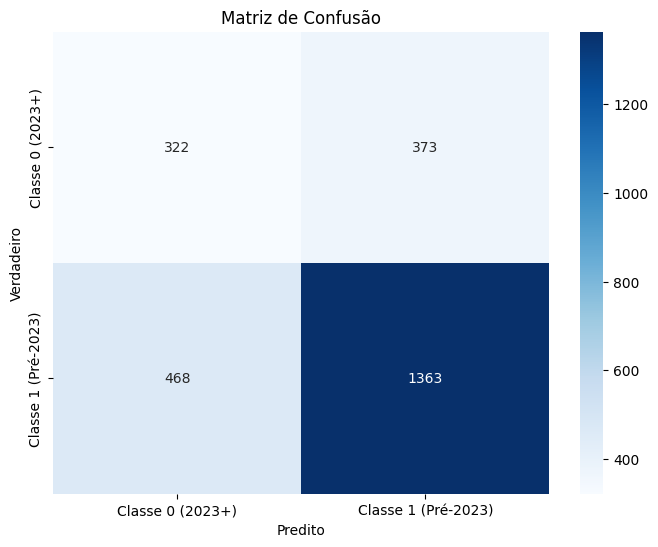

In [54]:
# Avaliação

# Avaliação básica com Keras
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia (Keras): {accuracy * 100:.2f}%")
print(f"Loss (Keras): {loss:.4f}\n")

# 2. Predições do modelo para o conjunto de teste (Probabilidades)
y_pred_prob = model.predict(X_test)

# 3. Converção em classes (0 ou 1). Se a prob > 0.5, então 1, senão 0.
y_pred = (y_pred_prob > 0.5).astype("int32")

# 4. Classificação Detalhada
print("Relatório de Classificação:")
# 0: 2023 ou DEPOIS
# 1: ANTES de 2023
target_names = ['Classe 0 (2023+)', 'Classe 1 (Pré-2023)']
print(classification_report(y_test, y_pred, target_names=target_names))

# 5. Matriz de Confusão
print("Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [12]:
model.save('classificador_com_ELMo.keras')